In [1]:
import numpy as np
from scipy import stats as st
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

In [38]:
def discretize(Z, Zdim, Zmin, Zstep):
    ###
    #Discretize a variable Z using its dimension Zdim, its minimal values along each axis and the discretization steps
    res = [0]*Zdim #n-dimensional index
    for i in range(Zdim): #For each dimension
        elt = Z[i] #Extract the i-th element
        ind = int((elt - Zmin[i])//Zstep[i]) #Discretize
        res[i] = ind
    return(tuple(res)) #Return as tuple for array indexing

def discretize_Control(Z,Zmin,Zstep):
    elt = Z
    ind = int((elt - Zmin)//Zstep)
    return[ind]

def DKL(f,g):
    ###
    #Calculate the DKL of two 2D pfs
    div = 0 #Initialize
    for i in range(50):
        for j in range(50):
            if g[i][j] != 0 and f[i][j] != 0: #For numerical safety we will only integrate over the support of both functions (in practice this is compliant with the definition of the DKL)
                div = div + f[i][j]*(np.log(f[i][j]) - np.log(g[i][j]))
    return(div)

def KL_divergence(p, q):
    # Checking if both data sets have the same shape
    if p.shape != q.shape:
        raise ValueError('Both data sets must have the same shape')
    # Normalizing the binned data sets to obtain probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Calculating the KL divergence
    KL = np.sum(np.where((p != 0) & (q != 0) , p * (np.log(p) - np.log(q)), 0))
    
    return KL

def state_cost(ind):
    #cost = np.sqrt((ind[0]-25)**2)+0.1*np.sqrt((ind[1]-25)**2) #actual cost
    
    cost = 4.16*np.sqrt((ind[0]-25)**2)+2.44*np.sqrt((ind[1]-25)**2) #estimated cost
    return(cost)

def state_cost_cont(state):
    cost = ((state[0]-0)**2)+0.1*((state[1]-0)**2) #actual cost
    
    #cost = 4000.16*((state[0]-0)**2)+20.44*((state[1]-0)**2) #estimated cost
    #cost = 13.8*(np.cos(state[0])-np.cos(0))**2-8.5*(np.cos(state[0]-np.cos(np.pi)))
    return(cost)


def C_Bar(state,U_dis):
    
    ind = discretize(state, 2, [-np.pi, -5], [2*np.pi/50, 0.2])
    Expected_Cost = np.zeros((20,1)) #initialize cost
    Cost = 0
    for i in range(20):
        f = plant_actual[ind[0],ind[1],i] #Get the actual and demonstrator plants from the binned data
        for (index, x) in np.ndenumerate(f):
            Cost += x*state_cost(index)
        Expected_Cost[i,:]=Cost#Cost.append(cost)
    #Cost_sum = np.sum(np.array(Cost))
    Expected_Cost = np.sum(np.multiply(U_dis,Expected_Cost.T))
    #Expected_Cost_Sum = np.sum(Expected_Cost)
    return(Expected_Cost)
            
def feature(ind):
    #ind = discretize(state, 2, [-np.pi, -5], [2*np.pi/50, 0.2])
    feature1 = ((ind[0]-0.0)**2)
    feature2 = ((ind[1]-0.0)**2)
    feature3 = (ind[0]-50)
    feature4 = (state[0]-0)
    f = np.reshape(np.array([feature1,feature2]),(2,))
    return(f)

def state_expectation(pdf,S_axis):
    S1 = S_axis.dot(np.sum(pdf,1))
    S2 = S_axis.dot(np.sum(pdf,0))
    
    return np.array([S1,S2]) 

def system_model(state, u,m):
    l = 0.6
    max_torque = 2.5
    max_speed = 5
    state = np.array([0,0])
    #last_input = None
    g = 9.81
    dt = 0.1
    angle_std = 3*2*np.pi/360
    speed_std = 0.1
    #Simulation step
    u = np.clip(u, -max_torque, max_torque) #Clip the input as safety
    
    accel = u/(m*l*l) + g*np.sin(state[0])/l #Dynamics for the acceleration
    
    speed = state[1]
    angle = state[0]
    
    new_speed = speed + accel*dt + np.random.normal(0,speed_std) #Calculate the new speed
    new_speed = np.clip(new_speed, -max_speed, max_speed) #Clip the speed as safety (in practice the bounds were chosen to ensure this very rarely happens)
    
    new_angle = angle + speed*dt + np.random.normal(0,angle_std) #New angle
    if new_angle < -np.pi: #Angle is modulo 2\pi
        new_angle = new_angle + 2*np.pi
    if new_angle > np.pi:
        new_angle = new_angle - 2*np.pi
    
    next_state = np.array([new_angle, new_speed])   
    return next_state

def calculate_relative_entropy(f, g, sample_size):
    """
    Calculate the relative entropy between two multivariate normal distributions.

    Args:
        f: scipy.stats.multivariate_normal object representing the first distribution
        g: scipy.stats.multivariate_normal object representing the second distribution
        sample_size: int, the number of samples to draw for estimating the entropy

    Returns:
        relative_entropy: float, the relative entropy between f and g
    """
    # Generate samples from f and g
    samples_f = f.rvs(sample_size)
    samples_g = g.rvs(sample_size)

    # Estimate the probability density function (PDF) values
    pdf_f = f.pdf(samples_f)
    pdf_g = g.pdf(samples_g)

    # Calculate the relative entropy
    #relative_entropy = np.sum(pdf_f * np.log(pdf_f / pdf_g))
    
    KL = np.sum(np.where((pdf_f != 0) & (pdf_g != 0) , pdf_f * (np.log(pdf_f) - np.log(pdf_g)), 0))

    return KL


#import numpy as np
#from scipy.stats import multivariate_normal

def calculate_kl_divergence(mu1, cov1, mu2, cov2):
    """
    Calculate the Kullback-Leibler (KL) divergence between two multivariate Gaussian distributions.

    Args:
        mu1: numpy array of shape (d,), the mean vector of the first Gaussian distribution
        cov1: numpy array of shape (d, d), the covariance matrix of the first Gaussian distribution
        mu2: numpy array of shape (d,), the mean vector of the second Gaussian distribution
        cov2: numpy array of shape (d, d), the covariance matrix of the second Gaussian distribution

    Returns:
        kl_divergence: float, the KL divergence between the two Gaussian distributions
    """
    d = len(mu1)

    # Invert the covariance matrix of the second Gaussian distribution
    cov2_inv = np.linalg.inv(cov2)

    # Calculate the trace term
    trace_term = np.trace(np.matmul(cov2_inv, cov1))

    # Calculate the squared difference in means
    mean_diff = mu2 - mu1
    mean_diff_term = np.dot(np.dot(mean_diff, cov2_inv), mean_diff)

    # Calculate the log-determinant term
    log_det_term = np.log(np.linalg.det(cov2) / np.linalg.det(cov1))

    # Calculate the KL divergence
    kl_divergence = 0.5 * (trace_term + mean_diff_term - d + log_det_term)

    return kl_divergence

def wrap_angle(angle):
    wrapped_angle = angle % (2 * math.pi)
    if wrapped_angle > math.pi:
        wrapped_angle -= 2 * math.pi
    return wrapped_angle

def transfer_points(points):
    transferred_points = []
    for point in points:
        transferred_point = point + (2 * math.pi)
        if transferred_point > 0:
            transferred_point -= 2 * math.pi
        transferred_points.append(transferred_point)
    return transferred_points

   

In [3]:
u_axis_1 = np.array(np.linspace((-0.005),(0.005),20))

-1.0000163297347886

In [4]:
#Get the input axis
u_axis_2 = np.array(np.linspace((-2.5),(2.5),20))

#Load the plants obtained from the binning (warning, big files)
plant_target = np.load('plant_l06_m05.npy')
plant_actual = np.load('plant_l06_m1.npy')

print(plant_target.shape)

(50, 50, 20, 50, 50)


In [5]:
GP_f = pickle.load(open('GP_m1.dump','rb'))
GP_g = pickle.load(open('GP_m05.dump','rb'))

In [6]:
print("GPML kernel: %s" % GP_f.kernel_)
print("Log-marginal-likelihood:", GP_f.log_marginal_likelihood(GP_f.kernel_.theta, eval_gradient = True))

print("GPML kernel: %s" % GP_g.kernel_)
print("Log-marginal-likelihood:", GP_g.log_marginal_likelihood(GP_g.kernel_.theta, eval_gradient = True))

GPML kernel: 10**2 * RBF(length_scale=2.8) + WhiteKernel(noise_level=0.308)
Log-marginal-likelihood: (-3968.55513442545, array([-9.06762089e-06,  6.68663255e-05,  8.33511206e-04]))
GPML kernel: 8.63**2 * RBF(length_scale=2.62) + WhiteKernel(noise_level=0.291)
Log-marginal-likelihood: (-3880.999947858876, array([ 6.63423194e-07, -2.79053052e-06, -7.11052292e-06]))


In [31]:
class Pendulum():
    def __init__(self):
        self.l = 0.6
        self.m = 1
        self.max_torque = 2.5
        self.max_speed = 5
        self.state = np.array([0,0])
        self.last_input = None
        self.g = 9.81
        self.dt = 0.1
        self.angle_std = 3*2*np.pi/360
        self.speed_std = 0.1
        
    def random_init(self):
        ###
        #Random initialization
        self.state = np.array([np.random.uniform(-np.pi, np.pi),np.random.uniform(-sefl.max_speed, self.max_speed)])
        
    def step(self, u):
        #Simulation step
        u = np.clip(u, -self.max_torque, self.max_torque) #Clip the input as safety
        self.last_input = u
        accel = u/(self.m*self.l*self.l) + self.g*np.sin(self.state[0])/self.l #Dynamics for the acceleration
        
        speed = self.state[1]
        angle = self.state[0]
        
        new_speed = speed + accel*self.dt + np.random.normal(0,self.speed_std) #Calculate the new speed
        new_speed = np.clip(new_speed, -self.max_speed, self.max_speed) #Clip the speed as safety (in practice the bounds were chosen to ensure this very rarely happens)
        
        new_angle = angle + speed*self.dt + np.random.normal(0,self.angle_std) #New angle
        if new_angle < -np.pi: #Angle is modulo 2\pi
            new_angle = new_angle + 2*np.pi
        if new_angle > np.pi:
            new_angle = new_angle - 2*np.pi
        
        self.state = np.array([new_angle, new_speed])
        
    def set_state(self, angle, speed):
        ###
        #Explicitely set the state
        speed = np.clip(speed, -self.max_speed, self.max_speed)
        if angle < -np.pi:
            angle = angle + 2*np.pi
        if angle > np.pi:
            angle = angle - 2*np.pi
        self.state = np.array([angle, speed])

    def Control_step(self, u,uH):
        ###
        #Perform an FPD step given an expert input, by first getting the corresponding pf and then applying the FPD solution
        tpf = st.norm.pdf(u_axis, 0, 0.2) #Input pf
        S = np.sum(tpf) #Normalizing input pf
        target_pf = [x/S for x in tpf]
        
        ind = discretize(self.state, 2, [-np.pi, -5], [2*np.pi/50, 0.2]) #Discretize the state index for DKL calculation
        
        pf = np.zeros(20) #Initialize pf
        for i in range(20):
            f = plant_actual[ind[0],ind[1],i] #Get the actual and demonstrator plants from the binned data
            g = plant_target[ind[0],ind[1],i]
            log_DKL = np.exp(-KL_divergence(f,g)-C_Bar(self.state,target_pf))
            if log_DKL == 0.:
                log_DKL = 0.0000001
            pf[i] = target_pf[i]*log_DKL #Calculate the DKL for each possible input, get corresponding probability
        S2 = np.sum(pf) #Normalize resulting policy
        #print(pf)
        pf = [x/S2 for x in pf]
        action = np.random.choice(u_axis, p=pf) #Select a random action from the new policy
        previous_action = action
        self.step(action) #Simulation step
        
        
    def Control_step_continous(self, u,uH):
        ###
        #Perform an FPD step given an expert input, by first getting the corresponding pf and then applying the FPD solution
        tpf = st.norm.pdf(u_axis_2, u, 0.2) #Input pf
        S = np.sum(tpf) #Normalizing input pf
        target_pf = [x/S for x in tpf]
        
        #ind = discretize(self.state, 2, [-np.pi, -5], [2*np.pi/50, 0.2]) #Discretize the state index for DKL calculation
        
        self.pf = np.zeros(20) #Initialize pf
        for i in range(20):
            GP_input_f = np.reshape(np.array([self.state[0],self.state[1],u_axis_2[i]]),(1,3))
            GP_input_g = np.reshape(np.array([self.state[0],self.state[1],u_axis_1[i]]),(1,3))
            next_state_f,sigma_f= GP_f.predict(GP_input_f,return_std=True)
            next_state_g,sigma_g= GP_g.predict(GP_input_g,return_std=True)
            
            cov_f = np.diag(sigma_f.reshape((2,))**2)
            cov_g = np.diag(sigma_g.reshape((2,))**2)
            
            f = st.multivariate_normal(next_state_f.reshape((2,)),cov_f) #Get the actual and demonstrator plants from the binned data
            f_samples = f.rvs(100)
            
            
            for j in range(100):
                cost = 0
                cost += state_cost_cont(f_samples[j,:])
            
            log_DKL = np.exp(-calculate_kl_divergence(next_state_f.reshape((2,)),cov_f,next_state_g.reshape((2,)),cov_g)-cost/100)            #if log_DKL == 0.:
            #    log_DKL = 1e-10
            self.pf[i] = target_pf[i]*log_DKL #Calculate the DKL for each possible input, get corresponding probability
        S2 = np.sum(self.pf) #Normalize resulting policy
        #print(pf)
        self.pf = [x/S2 for x in self.pf]
        self.action = np.random.choice(u_axis_2, p=self.pf) #Select a random action from the new policy
        #previous_action = action
        self.step(self.action) #Simulation step
        


In [8]:
P = Pendulum()
P.m

1

In [10]:
###
#The following cells are dedicated to building the MPC controller used for the expert policy. Refer to the MPC file for details

In [13]:
import numpy as np
import sys
from casadi import *
import do_mpc


model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [14]:
theta = model.set_variable(var_type='_x', var_name='theta', shape=(1,1))
dtheta = model.set_variable(var_type='_x', var_name='dtheta', shape=(1,1))

u = model.set_variable(var_type='_u', var_name='u', shape=(1,1))

In [15]:
m = 0.5
l = 0.6

g = 9.81

In [16]:
model.set_rhs('theta',dtheta)
model.set_rhs('dtheta', g*sin(theta)/l + u/(m*l*l))

In [17]:
model.setup()

In [18]:
mpc = do_mpc.controller.MPC(model)

In [19]:
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 0,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

In [20]:
l_term = theta*theta + 0.1*dtheta*dtheta
m_term = theta*theta + 0.5*dtheta*dtheta
mpc.set_objective(mterm=m_term, lterm=l_term)

In [21]:

mpc.bounds['lower','_u', 'u'] = -2.5
mpc.bounds['upper','_u', 'u'] = 2.5

In [22]:
mpc.setup()

c:\Users\jamal\anaconda3\envs\mbrl\lib\site-packages\do_mpc\controller.py:904: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


In [23]:
x0 = np.array([np.pi, 0]).reshape(-1,1)
mpc.x0 = x0

In [24]:
mpc.set_initial_guess()

In [25]:
mpc.reset_history()

In [39]:
%%capture
nSims = 20
nSteps = 300
fullH1 = np.zeros((nSims,nSteps-1))
fullH2 = np.zeros((nSims,nSteps-1))
uH = np.zeros((nSims,nSteps-1))
pf = np.zeros((nSims,nSteps-1,20))
#uHL = 
for j in range(nSims): #Perform 10 simulations
    hist = [[0,0]]*nSteps
    uhist = [0]*nSteps

    P1 = Pendulum() #Initialize a new pendulum
    P1.m = 1
    P1.set_state(np.pi,0) #Set the new pendulum to the initial state
    mpc.reset_history()
    for i in range(nSteps-1): #For each step in the simulation
        state = P1.state #Get the state
        hist[i+1] = state #Log the state
        x0 = state.reshape(-1,1)
        u0 = mpc.make_step(x0) #Get the demonstrator action
        u = u0[0][0]
        P1.Control_step_continous(u,u) #Perform a step: get expert policy from action, derive actual policy, sample, simulate
        uhist[i] = P1.action #Log action
        pf[j,i,:] = P1.pf
        print('Step Number:'+str(i))
    fullH1[j] = [x[0] for x in hist[1:]]
    fullH2[j] = [x[1] for x in hist[1:]]
    uH[j] = uhist[:nSteps-1]

In [ ]:
#Saving trajectory data

np.save("State_H13.npy",fullH1[:,:])
np.save("State_H23.npy",fullH2[:,:])
np.save("Control_H3.npy",uH[:,:])

In [27]:
#Loading Trajectory Data

SH1 = np.load("State_H13.npy")
SH2 = np.load("State_H23.npy")
UH = np.load("Control_H3.npy")

print(np.shape(SH1[19,:]))

(299,)


In [186]:
SH1 = np.reshape(SH1,(SH1.shape[0]*SH1.shape[1]))
SH2 = np.reshape(SH2,(SH2.shape[0]*SH2.shape[1]))

UH = np.reshape(UH,(UH.shape[0]*UH.shape[1]))

In [185]:
#Removing outliers from the trajectory data

SH1 = np.delete(SH1,[19,20,21,22,23,24,25,26],axis=1)
SH2 = np.delete(SH2,[19,20,21,22,23,24,25,26],axis=1)
UH = np.delete(UH,[20,21,22,23,24,25,26,27],axis=1)

In [297]:
def feature(ind):
    f1 = (np.cos(ind[0])-1.0)**2
    f2 = (np.cos(ind[0])-np.cos(np.pi))**2
    f = np.reshape(np.array([f1,f2]),(2,))
    return(f)

In [298]:
%%capture
import cvxpy as cp
import numpy as np
import time
M = 298
N_features = 2
w = cp.Variable((1,N_features))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []
#S_axis = np.array([i for i in range(50)])

#f_expect = np.zeros((N_features,20)) 
features = np.zeros((N_features,20,M))
#f_sampled = np.zeros((N_features,M)) 
feature_sampled = np.zeros((N_features,M))
PF = np.zeros((20,M))
pf = np.zeros(20)
Log_DKL_1 = np.zeros((20,M))
Log_DKL_2 = np.zeros((20,M))
KL = np.zeros((20,M))

for i in range(M):

    #############################################################################################################################
    state = np.array([S1[i],S2[i]]) #Get the state

    x0 = state.reshape(-1,1)
    u0 = mpc.make_step(x0) #Get the demonstrator action
    u = u0[0][0]
    
    tpf = st.norm.pdf(u_axis_2, u, 0.2) #Input pf
    S = np.sum(tpf) #Normalizing input pf
    target_pf = [x/S for x in tpf]
    
    for j in range(20):
        
        GP_input = np.reshape(np.array([state[0],state[1],u_axis_2[j]]),(1,3))
        next_state_f,sigma_f= GP_f.predict(GP_input,return_std=True)
        next_state_g,sigma_g= GP_g.predict(GP_input,return_std=True)
            
        cov_f = np.diag(sigma_f.reshape((2,))**2)
        cov_g = np.diag(sigma_g.reshape((2,))**2)
        
        f = st.multivariate_normal(next_state_f.reshape((2,)),cov_f) #Get the actual and demonstrator plants from the binned data
        
        N_samples = 500
        f_samples = f.rvs(N_samples)
            
        feature_expect = np.zeros((N_features,N_samples))
            
        for k in range(N_samples):
            feature_expect[:,k] = feature(f_samples[k,:])
        
        features[:,j,i] = np.mean(feature_expect,axis=1) # calculating feature vector
        KL[j,i] = calculate_kl_divergence(next_state_f.reshape((2,)),cov_f,next_state_g.reshape((2,)),cov_g)
        log_DKL = np.exp(-KL[j,i])
        Log_DKL_1[j,i] = log_DKL
        if log_DKL == 0.0:
            log_DKL = 1e-10
        Log_DKL_2[j,i] = log_DKL    
        pf[j] = target_pf[j]*log_DKL 
    PF[:,i] = pf
    
    
    GP_input_single = np.reshape(np.array([state[0],state[1],U[i]]),(1,3))
    next_state_f_single,sigma_f_single= GP_f.predict(GP_input_single,return_std=True)
    
    cov_f_single = np.diag(sigma_f_single.reshape((2,))**2)
    f_single = st.multivariate_normal(next_state_f_single.reshape((2,)),cov_f_single) 
    f_sample_single = f_single.rvs(N_samples)
    feature_expect_single = np.zeros((N_features,N_samples))
            
    for k in range(N_samples):
        feature_expect_single[:,k] = feature(f_sample_single[k,:])
    feature_sampled[:,i] = np.mean(feature_expect_single,axis=1)
    
    
    L.append(-(w @ feature_sampled[:,i]) + cp.log_sum_exp(cp.reshape(w @ features[:,:,i],(20,)) + cp.log(PF[:,i]))) #Log likelihood for each instance
   
     
objective = cp.Minimize(cp.sum(L))    
    
prob = cp.Problem(objective)

result = prob.solve(verbose = True)

print("status:", prob.status)
print("optimal value", prob.value)

In [324]:
weights = w.value
np.save('weights.npy',weights)
print('Weights =',weights)

Weights = [[-13.66639622   8.56125564]]


In [28]:
nSteps = 300

In [28]:
import math
S_t = transfer_points(SH1[0,:])
S_t = np.array(S_t)

In [40]:
means = [0]*(nSteps-1) #Average and std over the simulations
stds = [0]*(nSteps-1)
for i in range(nSteps-1):
    means[i] = np.mean(fullH1[:,i])
    stds[i] = np.std(fullH1[:,i])
    
#S1 = np.array(means)    

In [41]:
means2 = [0]*(nSteps-1) #Average and std over the simulations
stds2 = [0]*(nSteps-1)
for i in range(nSteps-1):
    means2[i] = np.mean(fullH2[:,i])
    stds2[i] = np.std(fullH2[:,i])

#S2 = np.array(means2)        

In [42]:
umeans = [0]*(nSteps-1)
ustds = [0]*(nSteps-1)
for i in range(nSteps-1):
    umeans[i] = np.mean(uH[:,i])
    ustds[i] = np.std(uH[:,i])
    
#U = np.array(umeans) 
    

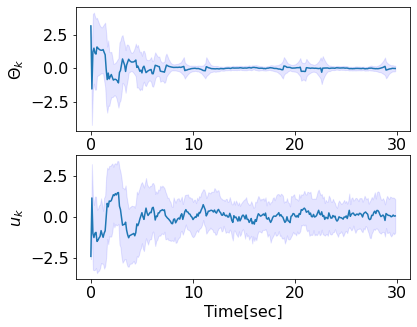

In [43]:
from matplotlib import pyplot as plt
from pylab import rcParams
plt.rcParams.update({'font.size': 16})

x = np.array([x/10 for x in range(nSteps-1)])
y = np.array(means)
ci = np.array(stds)

x_u = np.array([x/10 for x in range(nSteps-1)])
y_u = np.array(umeans)
ci_u = np.array(ustds)

fig, ax = plt.subplots(2,1)
fig.figure.set_figheight(5)
ax[0].plot(x,y)
ax[0].fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
ax[0].set_ylabel('$\Theta_{k}$')

ax[1].plot(x_u,y_u)

ax[1].fill_between(x_u, (y_u-ci_u), (y_u+ci_u), color='b', alpha=.1)

ax[1].set_xlabel('Time[sec]')
ax[1].set_ylabel('$u_{k}$')

plt.savefig('GP_pendulum_joint_ci_1m_0.6l.jpeg',bbox_inches ='tight')